In [65]:
import cv2
import easyocr
from IPython.display import Image, display
import numpy as np
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import re

Ultralytics YOLOv8.0.119 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.4/78.2 GB disk)


In [66]:
# !pip install ultralytics

In [67]:
# Load a pretrained model
model = YOLO('/content/best.pt')
model.conf = 0.4  # Confidence threshold for detection


In [78]:
def preprocess_image(image):
    # Convert to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Display the grayscale image
    display(Image(data=cv2.imencode('.jpg',grayscale_image)[1].tobytes()))
    # # Apply denoising filter
    # denoised_image = cv2.GaussianBlur(grayscale_image, (3, 3), 0)
    # Apply contrast enhancement
    # equalized_image = cv2.equalizeHist(grayscale_image)
    # Display the preprocessed image
    # display(Image(data=cv2.imencode('.jpg', equalized_image)[1].tobytes()))
    # Apply image sharpening
    sharpened_image = cv2.filter2D(grayscale_image, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
    # Display the preprocessed image
    display(Image(data=cv2.imencode('.jpg', sharpened_image)[1].tobytes()))
    return grayscale_image

In [69]:
def threshold(image):
    # Apply Otsu thresholding
    _, threshold_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Display the threshold image
    display(Image(data=cv2.imencode('.jpg',threshold_image)[1].tobytes()))
    return threshold_image

In [70]:
def ocrImage(image):
    # Perform OCR on the thresholded image
    recognized_plates=[]
    reader = easyocr.Reader(['en', 'ne'])
    result = reader.readtext(image, allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ ', detail=0)
    recognized_plates = [''.join(result)]
    return recognized_plates


In [71]:
# reader = easyocr.Reader(['en', 'ne'])

In [81]:
def recognize_number_plate(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Initialize variables for best frame and its corresponding recognized plate
    best_frame = None
    best_plate = None

    # Read frames from the video
    while True:
        ret, frame = video.read()

        # Check if a frame was successfully read
        if not ret:
            break

        # Perform object detection using YOLO
        detections = model(frame)

        # Extract bounding boxes and crop number plate regions
        number_plate_box = None
        for detection in detections[0].boxes.data:
            if detection[5] == 0:
                number_plate_box = detection[:4]
                break

        # Check if the current frame has a better recognized plate than the previous best frame
        if number_plate_box is not None:
            x1, y1, x2, y2 = number_plate_box

            # Calculate the area of the number plate region
            plate_area = (x2 - x1) * (y2 - y1)

            # Compare the plate area with the previous best frame
            if best_frame is None or plate_area > best_plate_area:
                best_frame = frame.copy()
                best_plate_area = plate_area

    # Release the video file
    video.release()

    # Apply OCR on the best frame
    if best_frame is not None:
        # Perform object detection on the best frame
        detections = model(best_frame)

        # Extract bounding box of the number plate region
        number_plate_box = None
        for detection in detections[0].boxes.data:
            if detection[5] == 0:
                number_plate_box = detection[:4]
                break
        # Display the best frame with bounding box and recognized plate
        display(Image(data=cv2.imencode('.jpg', best_frame)[1].tobytes()))

        # Crop the number plate region from the best frame
        if number_plate_box is not None:
            x1, y1, x2, y2 = number_plate_box
            cropped_image = best_frame[int(y1):int(y2), int(x1):int(x2)]
            # Display the cropped image
            display(Image(data=cv2.imencode('.jpg', cropped_image)[1].tobytes()))

            grayscale_image= preprocess_image(cropped_image)
            # threshold_image=threshold(grayscale_image)
            best_plate= ocrImage(grayscale_image)


            # Draw bounding box on the best frame
            cv2.rectangle(best_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)



        # Print the recognized plate
        print("Best Plate:", best_plate)
    else:
        print("Number plate not found.")



0: 480x800 1 License-plate, 15.5ms
Speed: 4.1ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 800, 800)

0: 480x800 1 License-plate, 15.4ms
Speed: 2.3ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 800, 800)

0: 480x800 1 License-plate, 15.4ms
Speed: 3.4ms preprocess, 15.4ms inference, 1.4ms postprocess per image at shape (1, 3, 800, 800)

0: 480x800 1 License-plate, 15.4ms
Speed: 3.7ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 800, 800)

0: 480x800 1 License-plate, 15.5ms
Speed: 2.5ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 800, 800)

0: 480x800 1 License-plate, 15.4ms
Speed: 2.7ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 800, 800)

0: 480x800 1 License-plate, 15.4ms
Speed: 3.2ms preprocess, 15.4ms inference, 1.3ms postprocess per image at shape (1, 3, 800, 800)

0: 480x800 1 License-plate, 15.4ms
Speed: 2.5ms preprocess, 15.4ms i

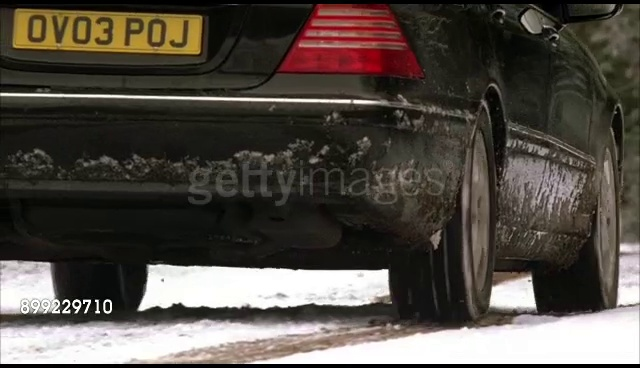

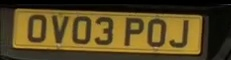

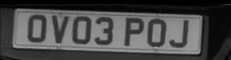

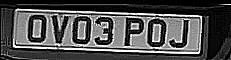

Best Plate: ['OVO3 POJ']


In [84]:
# Path to video file
video_path = '/content/12.mp4'
recognized_plates = recognize_number_plate(video_path)